<a href="https://colab.research.google.com/github/DanyaFire/StatPrac/blob/main/DZ_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

# Загрузим датасет
data = pd.read_csv('/content/drive/MyDrive/Python_KDA/forest_dataset.csv')
data.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2683,333,35,30,26,2743,121,173,179,6572,...,0,0,0,0,0,0,0,0,0,2
1,2915,90,8,216,11,4433,232,228,129,4019,...,0,0,0,0,0,0,0,0,0,1
2,2941,162,7,698,76,2783,227,242,148,1784,...,0,0,0,0,0,0,0,0,0,2
3,3096,60,17,170,3,3303,231,202,99,5370,...,0,0,0,0,0,0,0,0,0,1
4,2999,66,8,488,37,1532,228,225,131,2290,...,0,0,0,0,0,0,0,0,0,2


Дальше выделим метки и признаки.

In [2]:
labels = data[data.columns[-1]].values
feature_matrix = data[data.columns[:-1]].values

Разделим данные на тестовую и обучающую части.

In [3]:
train_feature_matrix, test_feature_matrix, train_labels, test_labels = train_test_split(feature_matrix, labels, test_size = 0.2, random_state = 42)

Обучаем модель kNN:

In [4]:
clf = KNeighborsClassifier(n_neighbors = 7, weights = "uniform", metric = "euclidean")
clf.fit(train_feature_matrix, train_labels)
y_pred = clf.predict(test_feature_matrix)

Определим точность предсказанных значений.

In [5]:
print(f'Predict accuracy: {round(accuracy_score(test_labels, y_pred) * 100)}%')

Predict accuracy: 73%


Введём экзогенные переменные (параметры) модели: число соседей, пару метрик: евклидову и манхэттэнскую, а также по-разному будем рассчитывать веса: равномерно и в зависимости от дистанции.

In [6]:
ekzo = {'n_neighbors': np.arange(1,11),
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']}
clf = KNeighborsClassifier()
clf_grid = GridSearchCV(clf, ekzo, cv = 5, scoring = 'accuracy', n_jobs = -1)
_ = clf_grid.fit(train_feature_matrix, train_labels)

Выведу параметры отдельно, чтобы не запускать каждый раз часть кода, которая запускатся минуту...

In [7]:
clf_grid.best_params_

{'metric': 'manhattan', 'n_neighbors': np.int64(4), 'weights': 'distance'}

Вычислим вероятности принадлежности к классам для тестовой выборки. Для этого используем оптимальное количество соседей, которое мы нашли ранее.

In [8]:
opt_clf = KNeighborsClassifier(**clf_grid.best_params_) # Передаём отдельные именованные аргументы
opt_clf.fit(train_feature_matrix, train_labels) # Обучаем классификатор на тренировочной выборке
pred_probability = opt_clf.predict_proba(test_feature_matrix) # Предсказание вероятности принадлежности тестовой выборки к классам
print("Probabilities of belongs to classes for the test sample:", pred_probability, sep = '\n')

Probabilities of belongs to classes for the test sample:
[[0.         1.         0.         ... 0.         0.         0.        ]
 [0.73117861 0.26882139 0.         ... 0.         0.         0.        ]
 [0.27814042 0.72185958 0.         ... 0.         0.         0.        ]
 ...
 [1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [0.54264548 0.         0.         ... 0.         0.         0.45735452]]


Нарисуем графики предсказаний.

7


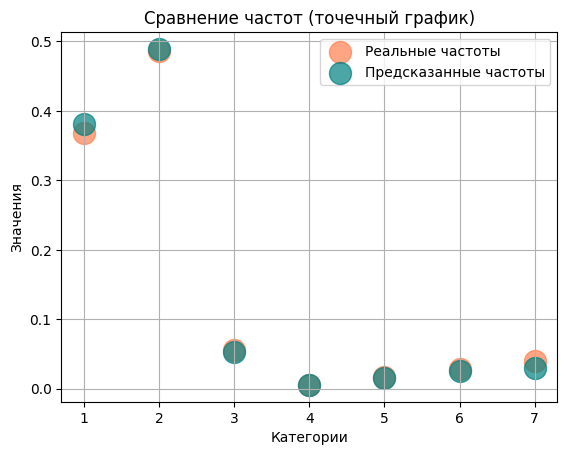

In [25]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

unique, freq = np.unique(test_labels, return_counts = True) # Нашли уникальные значения и частоту их появления
freq = np.array([x/len(test_labels) for x in freq])
# Попробуем предсказать частоту появления уникального значения
pred_freq = pred_probability.mean(axis = 0)
# print(pred_freq)
print(len(unique))
# Займёмся визуализацией

plt.scatter(range(1, len(unique) + 1), freq, color='coral', label='Реальные частоты', marker='o', s=250, alpha = 0.7)
plt.scatter(range(1, len(unique) + 1), pred_freq, color='teal', label='Предсказанные частоты', marker='o', s=250, alpha = 0.7)

plt.xlabel('Категории')
plt.ylabel('Значения')
plt.title('Сравнение частот (точечный график)')
plt.xticks(range(1, len(unique) + 1), unique)
plt.legend()
plt.grid(True)
plt.show()

Сравним точность моделей KNN и логистической регрессии.

In [27]:
pred_labels = opt_clf.predict(test_feature_matrix)
knn_accuracy = accuracy_score(test_labels, pred_labels)
print("KNN accuracy:", knn_accuracy)

clf = LogisticRegression(C = 1, solver = "newton-cholesky")
clf.fit(train_feature_matrix, train_labels)
y_pred = clf.predict(test_feature_matrix)

log_reg_accuracy = accuracy_score(test_labels, y_pred)
print("Logistic Regression accuracy:", log_reg_accuracy)
print("Difference between methods:", round(abs(knn_accuracy - log_reg_accuracy),5))

KNN accuracy: 0.7845
Logistic Regression accuracy: 0.7215
Difference between methods: 0.063


Заметим, что модель KNN показала точность выше, нежели логистическая регрессия. Таким образом, можем сделать вывод, что KNN классифицирует тестовую выборку лучше логистической регрессии.

Построим ROC-кривую для метода kNN и посчитаем площадь под ней.

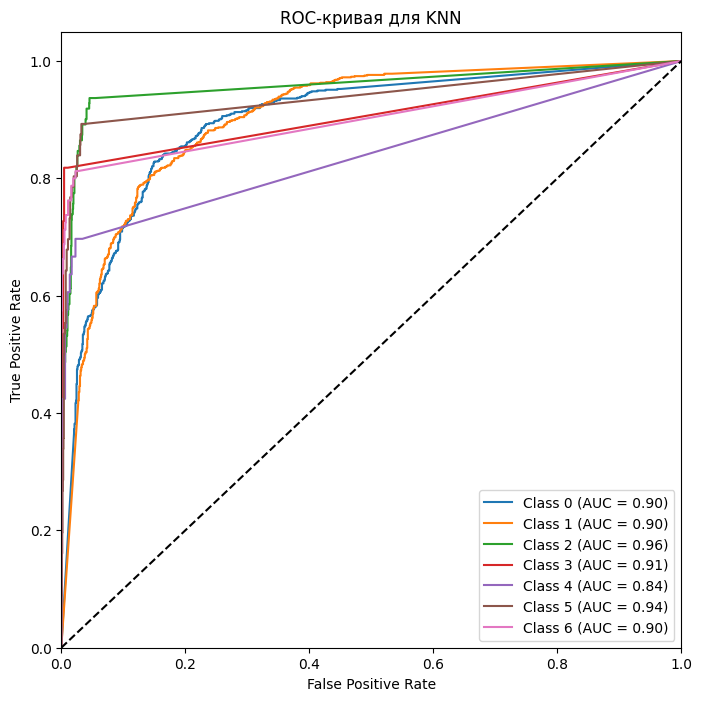

Mean AUC (AUC-ROC): 0.91


In [30]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

#Бинаризуем классы для ROC-AUC анализа
test_labels_bin = label_binarize(test_labels, classes = range(1, len(unique) + 1))
n_classes = test_labels_bin.shape[1]

#Строим ROC-кривую
plt.figure(figsize=(8, 8))

#Список для хранения значений AUC для каждого класса
roc_auc_values = []

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(test_labels_bin[:, i], pred_probability[:, i])  #получаем FPR и TPR
    roc_auc = auc(fpr, tpr)  #вычисляем AUC для этого класса
    roc_auc_values.append(roc_auc)  #сохраняем AUC

    # Строим ROC-кривую для каждого класса с отображением AUC в легенде
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Добавляем диагональ для случайной модели
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая для KNN')
plt.legend(loc="lower right")
plt.show()

#Рассчитываем и выводим среднее значение AUC (AUC-ROC)
mean_auc = np.mean(roc_auc_values)
print(f'Mean AUC (AUC-ROC): {mean_auc:.2f}')

***Анализ применимости метода k-ближайших соседей (KNN)***

Метод k-ближайших соседей (KNN) продемонстрировал определенную точность в нашей задаче, однако важно учитывать его зависимость от выбора параметра k (количество соседей) и метрики расстояния. Хотя логистическая регрессия является эффективным инструментом для линейно зависимых данных, в нашем случае KNN показал несколько более высокий результат. Этот факт указывает на присутствие нелинейных зависимостей в данных, которые KNN способен улавливать.


Поговорим про преимущества и недостатки KNN.

**Преимущества:**

*Простота и интуитивность:* Алгоритм KNN легко понять и реализовать.

*Нелинейные зависимости:* KNN эффективно работает в условиях, когда данные не имеют линейной структуры.

*“Ленивое” обучение:*  Модель не требует этапа обучения в явном виде; она просто хранит обучающие данные, что упрощает процесс.

**Недостатки:**

*Вычислительная сложность:* Поиск ближайших соседей требует значительного времени, особенно для больших наборов данных.

*Чувствительность к параметрам:* Результат сильно зависит от правильного выбора метрики расстояния и количества соседей (k).

*Проблемы с многомерностью:* В высокоразмерных пространствах KNN может терять эффективность из-за “проклятия размерности”.

*Оценка качества KNN:*
 Площадь под ROC-кривой (AUC)
Для оценки эффективности классификатора KNN используется площадь под ROC-кривой (AUC). AUC показывает, насколько хорошо модель различает классы при различных порогах вероятности.

AUC ≈ 1: Идеальный классификатор, отлично разделяющий классы.
AUC ≈ 0.5: Модель ведет себя как случайный классификатор.
Чем ближе значение AUC к 1, тем выше качество модели KNN в данной задаче. AUC позволяет оценить способность KNN правильно классифицировать объекты, варьируя порог отнесения к тому или иному классу.

**Вывод:**
Метод k-ближайших соседей может быть полезным инструментом в задачах классификации, особенно при наличии нелинейных зависимостей в данных. Однако необходимо тщательно подходить к выбору параметров k и метрики расстояния, а также учитывать вычислительную сложность алгоритма. В некоторых сценариях логистическая регрессия может оказаться более эффективным и менее ресурсоемким решением. Окончательный выбор между KNN и логистической регрессией, как и выбор любых других алгоритмов машинного обучения, должен основываться на тщательном анализе данных и экспериментальной оценке производительности каждой модели с использованием подходящих метрик качества, таких как AUC.